## Libraries

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

## Get Data

In [28]:
dat = pd.read_pickle('./data/processed/final/all-sched-enriched.pkl')
dat.head()

,operator,flight,aircraft,craft_capacity,frequency,weekly_flights,weekly_capacity,weekly_est_pass,from,from_time,...,to_time_slot,eff_from,eff_to,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,IND,6E 101,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,MAA,6.25,...,15.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
1,IND,6E 103,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,PNQ,22.33,...,1.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
2,IND,6E 104,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,HYD,8.17,...,23.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
3,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,PNQ,17.33,...,38.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,False,True
4,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,DEL,14.75,...,34.0,2019-10-27 00:00:00,2020-03-27 00:00:00,True,True,True,True,True,False,True


### Overview

In [3]:
n_flights = dat['weekly_flights'].sum()
operators = dat['operator'].unique()
n_operators = len(operators)
cities = list(set(dat['from'].tolist() + dat['to'].tolist()))
n_cities = len(cities)

print('In a week, %i operators run %i domestic flights into and out of %i Indian cities.\n' % 
      (n_operators, n_flights, n_cities))
print('A flight departs from and arrives into a different city, so the %i flights result in' % n_flights)
print('a weekly total of %i arrivals and departures.' % (2*n_flights))

In a week, 9 operators run 21953 domestic flights into and out of 102 Indian cities.

A flight departs from and arrives into a different city, so the 21953 flights result in
a weekly total of 43906 arrivals and departures.


### Top Cities by Traffic

<ul>
    <li>Take a slice of the dataframe that includes only relevant columns - <i>operator, from, to, weekly_flights, weekly_capacity, weekly_est_pass, from_time_slot, to_time_slot</i>.
    <li>Create a new datafram by wrangle the data slice to identify for each city, across all carriers:
        <ol>
            <li>weekly total number of flights (arrivals plus departures).
            <li>weekly capacity.
            <li>weekly estimated passengers
        </ol>
</ul>

Identify the top cities that account for 80% of all flights.

In [4]:
sdat = dat[['operator','from', 'to', 'weekly_flights', 'weekly_capacity', 'weekly_est_pass', 
            'from_time_slot', 'to_time_slot']]

weeklies_ = ['weekly_flights', 'weekly_capacity', 'weekly_est_pass']
from_flights = sdat.groupby(['from'])[weeklies_].sum()
to_flights = sdat.groupby(['to'])[weeklies_].sum()

city_weekly = pd.concat([from_flights, to_flights], axis = 1, ignore_index = True)
city_weekly = city_weekly.fillna(0, axis = 1, downcast = 'infer') # if there are no flights either from or 
                                                                  # to a city, replace NA by 0
city_weekly = city_weekly.rename(columns = {0:'from_weekly_flights', 
                                            3:'to_weekly_flights',
                                            1:'from_weekly_capacity',
                                            4:'to_weekly_capacity',
                                            2:'from_weekly_est_pass',
                                            5:'to_weekly_est_pass'}, errors = 'raise')

city_weekly['total_weekly_flights'] = city_weekly.apply(lambda row: 
                                                        row.from_weekly_flights + row.to_weekly_flights,
                                                        axis = 1)
city_weekly['total_weekly_capacity'] = city_weekly.apply(lambda row: 
                                                        row.from_weekly_capacity + row.to_weekly_capacity,
                                                        axis = 1)
city_weekly['total_weekly_est_pass'] = city_weekly.apply(lambda row: 
                                                        row.from_weekly_est_pass + row.to_weekly_est_pass,
                                                        axis = 1)

city_weekly.head()

,from_weekly_flights,from_weekly_capacity,from_weekly_est_pass,to_weekly_flights,to_weekly_capacity,to_weekly_est_pass,total_weekly_flights,total_weekly_capacity,total_weekly_est_pass
AGR,4,280,218,4,280,218,8,560,436
AGX,7,490,383,7,490,383,14,980,766
AIP,7,546,500,7,546,500,14,1092,1000
AJL,11,1342,1046,24,3782,3223,35,5124,4269
AMD,764,124123,109080,750,120574,105987,1514,244697,215067


#### Top Cities by Weekly Total Arrivals and Departures

20 cities account for 80% of all arrivals and departures.

Cities accounting for 80% of all arrivals and departures:
 ['New Delhi', 'Mumbai', 'Bangalore', 'Hyderabad', 'Kolkata', 'Chennai', 'Ahmedabad', 'Pune', 'Goa', 'Guwahati', 'Jaipur', 'Lucknow', 'Patna', 'Kochi', 'Bhubaneswar', 'Varanasi', 'Indore', 'Coimbatore', 'Bagdogra', 'Chandigarh']


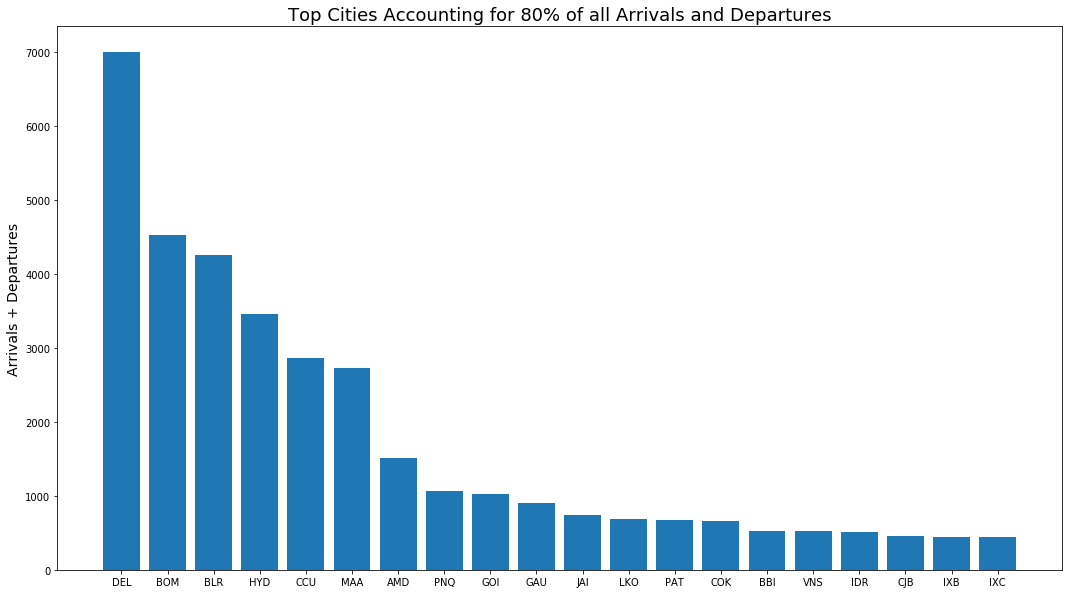

In [5]:
with open('./data/processed/codes_to_city_dict.txt', 'rb') as handle:
    codes_to_city = pickle.loads(handle.read())

city_weekly = city_weekly.sort_values(by = ['total_weekly_flights'], ascending = False)
total_ = city_weekly['total_weekly_flights'].sum()

city_weekly['%_total_weekly_flights'] = round(city_weekly['total_weekly_flights'].cumsum()/total_, 2)

top_cities_code = city_weekly.loc[city_weekly['%_total_weekly_flights'] <= 0.8, :].index.tolist()
top_cities = [codes_to_city[top_cities_code[i]] for i in range(len(top_cities_code))]

print('%i cities account for 80%% of all arrivals and departures.\n' % len(top_cities_code))
print('Cities accounting for 80% of all arrivals and departures:\n', top_cities)

plt.figure(figsize = (18, 10))
plt.bar(top_cities_code, city_weekly['total_weekly_flights'][0:len(top_cities)])
plt.title('Top Cities Accounting for 80% of all Arrivals and Departures', size = 18)
plt.ylabel('Arrivals + Departures', size = 14)
plt.show()

#### Top Cities by Weekly Total Capacity

17 cities account for 80% of total weekly capacity.

Cities accounting for 80% of total weekly capacity:
 ['New Delhi', 'Mumbai', 'Bangalore', 'Hyderabad', 'Kolkata', 'Chennai', 'Ahmedabad', 'Pune', 'Goa', 'Guwahati', 'Lucknow', 'Patna', 'Jaipur', 'Kochi', 'Bhubaneswar', 'Indore', 'Varanasi']


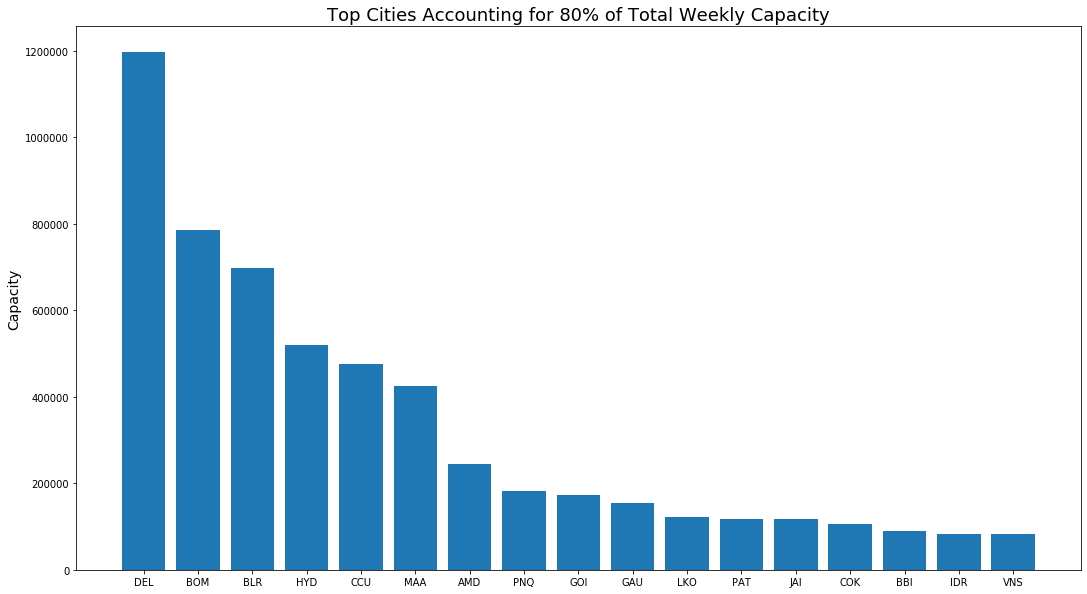

In [6]:
city_weekly = city_weekly.sort_values(by = ['total_weekly_capacity'], ascending = False)
total_ = city_weekly['total_weekly_capacity'].sum()

city_weekly['%_total_weekly_capacity'] = round(city_weekly['total_weekly_capacity'].cumsum()/total_, 2)

top_cities_code = city_weekly.loc[city_weekly['%_total_weekly_capacity'] <= 0.8, :].index.tolist()
top_cities = [codes_to_city[top_cities_code[i]] for i in range(len(top_cities_code))]

print('%i cities account for 80%% of total weekly capacity.\n' % len(top_cities_code))
print('Cities accounting for 80% of total weekly capacity:\n', top_cities)

plt.figure(figsize = (18, 10))
plt.bar(top_cities_code, city_weekly['total_weekly_capacity'][0:len(top_cities)])
plt.title('Top Cities Accounting for 80% of Total Weekly Capacity', size = 18)
plt.ylabel('Capacity', size = 14)
plt.show()

#### Top Cities by Weekly Total Estimated Passengers

17 cities account for 80% of total estimated weekly passengers.

Cities accounting for 80% of total estimated weekly passengers:
 ['New Delhi', 'Mumbai', 'Bangalore', 'Hyderabad', 'Kolkata', 'Chennai', 'Ahmedabad', 'Pune', 'Goa', 'Guwahati', 'Lucknow', 'Patna', 'Jaipur', 'Kochi', 'Bhubaneswar', 'Varanasi', 'Indore']


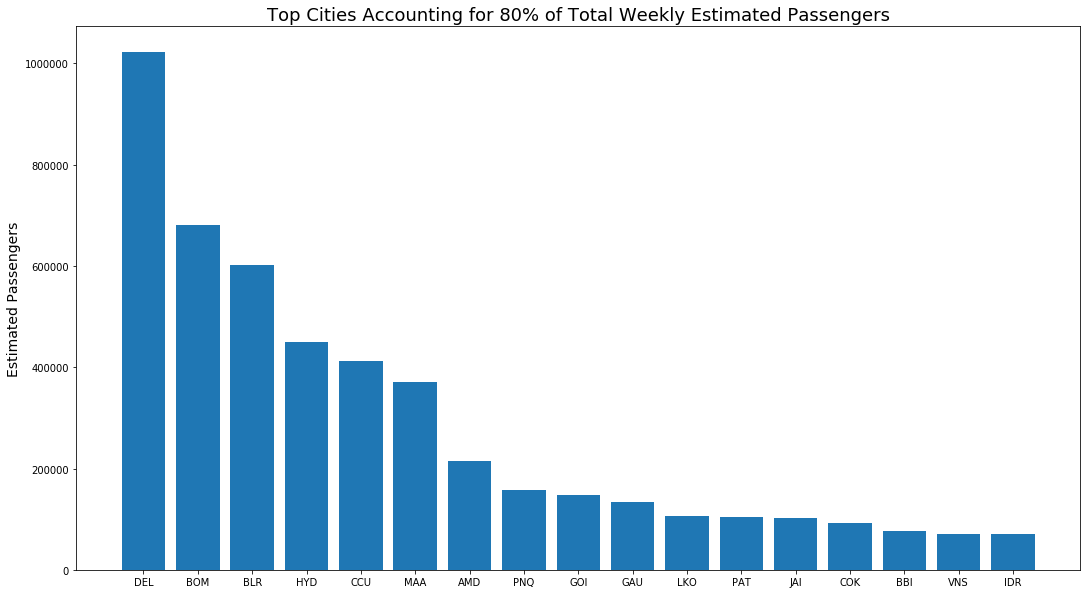

In [7]:
city_weekly = city_weekly.sort_values(by = ['total_weekly_est_pass'], ascending = False)
total_ = city_weekly['total_weekly_est_pass'].sum()

city_weekly['%_total_weekly_est_pass'] = round(city_weekly['total_weekly_est_pass'].cumsum()/total_, 2)

top_cities_code = city_weekly.loc[city_weekly['%_total_weekly_est_pass'] <= 0.8, :].index.tolist()
top_cities = [codes_to_city[top_cities_code[i]] for i in range(len(top_cities_code))]

print('%i cities account for 80%% of total estimated weekly passengers.\n' % len(top_cities_code))
print('Cities accounting for 80% of total estimated weekly passengers:\n', top_cities)

plt.figure(figsize = (18, 10))
plt.bar(top_cities_code, city_weekly['total_weekly_est_pass'][0:len(top_cities)])
plt.title('Top Cities Accounting for 80% of Total Weekly Estimated Passengers', size = 18)
plt.ylabel('Estimated Passengers', size = 14)
plt.show()

### Day-of-Week Traffic Distribution

<ul>
    <li>Plot the day-wise distribution for all cities combined.
    <li>For the top 10 cities by total estimated weekly passengers, for each city:
        <ol>
            <li>identify all schedules in and out of the city.
            <li>group the schedules by day of the week and count the total number of flights for the day.
            <li>plot the weekly spread of the total number of flights for the city

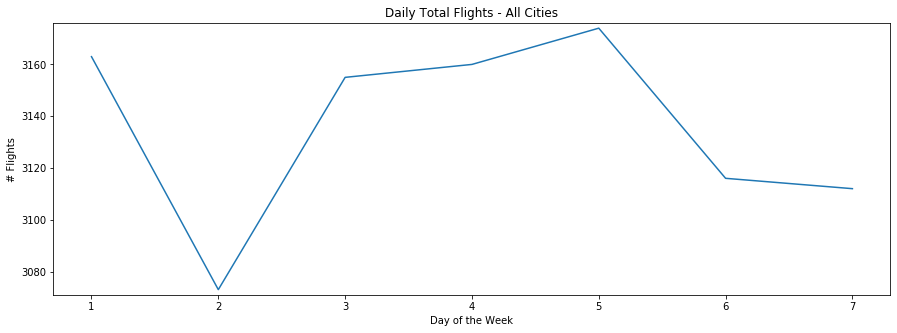

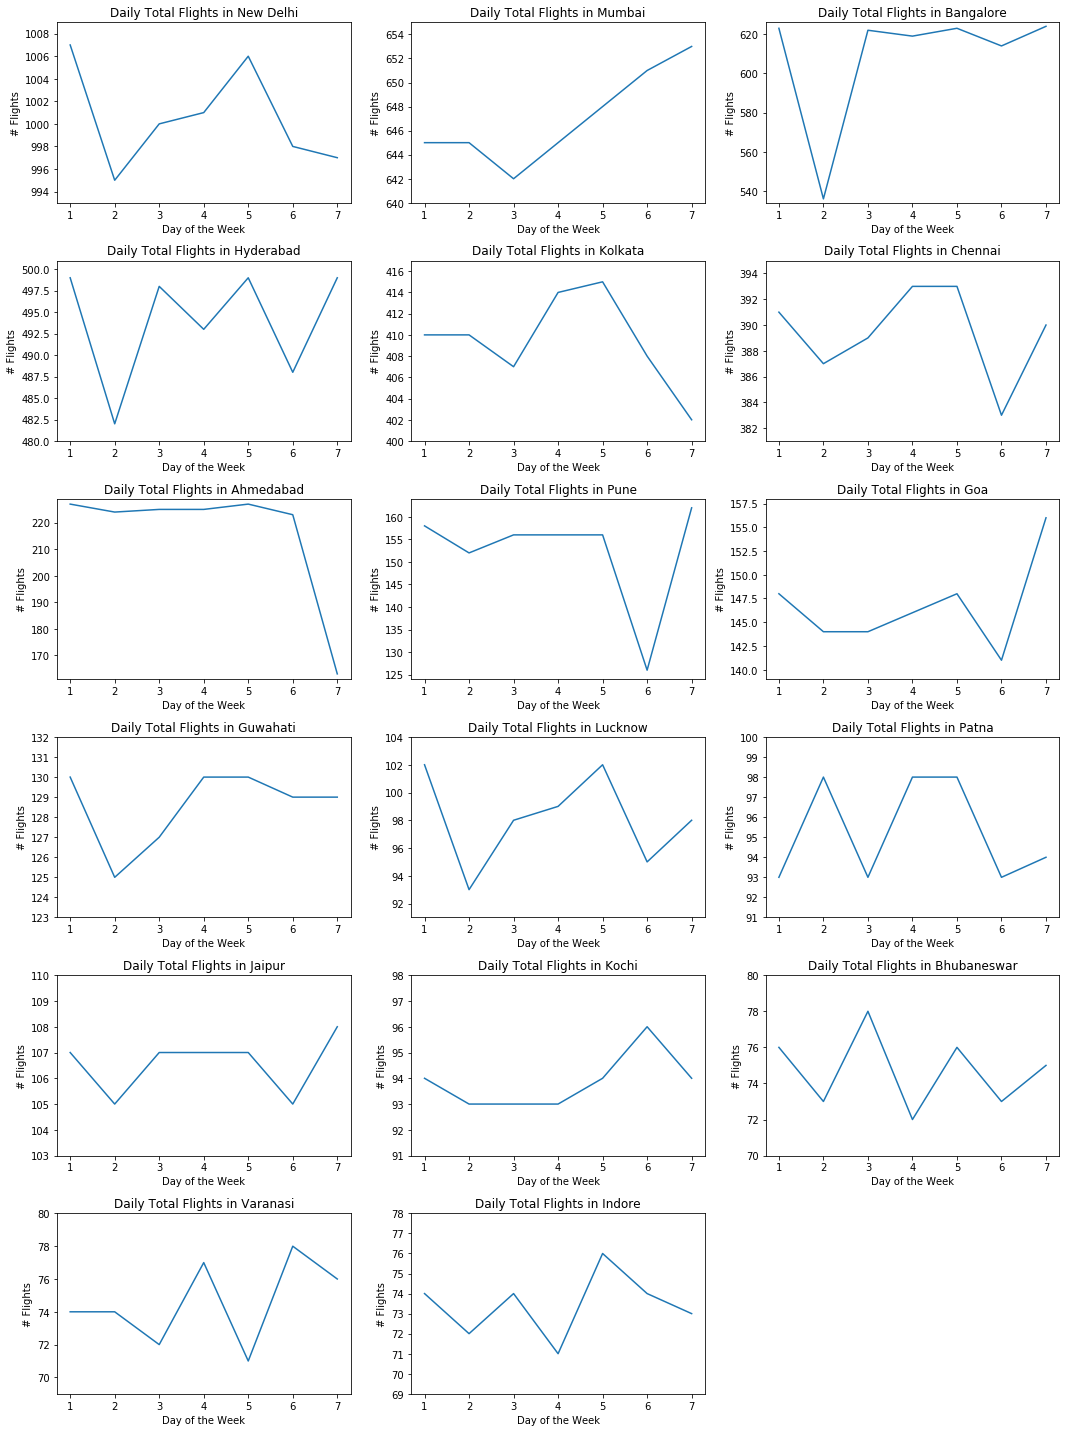

In [105]:
plt.figure(figsize = (15, 5))

idx = [i for i in range(dat.shape[0]) if dat['from'][i] != 'DEL' or dat['to'][i] != 'DEL']
sdat = dat.iloc[idx, :]
daily_flight_count = []
for i in range(1,8,1):
    foo = 'day_'+str(i)
    daily_flight_count.append(sdat.groupby([foo, 'from'])[foo].count()[1].sum())

plt.plot(np.arange(1,8,1), daily_flight_count)
plt.ylim((min(daily_flight_count) - 2, max(daily_flight_count) + 2))
plt.xlabel('Day of the Week')
plt.ylabel('# Flights')
plt.title('Daily Total Flights - All Cities')
plt.show()

plt.figure(figsize = (15, 20))
subplot_= 1
for city_code in top_cities_code:
    daily_flight_count = []
    idx = [i for i in range(dat.shape[0]) if dat['from'][i] == city_code or dat['to'][i] == city_code]
    sdat = dat.iloc[idx, :]
    
    for i in range(1,8,1):
        foo = 'day_'+str(i)
        daily_flight_count.append(sdat.groupby([foo, 'from'])[foo].count()[1].sum())
    
    plt.subplot(6,3, subplot_)
    subplot_ = subplot_ + 1
    plt.plot(np.arange(1,8,1), daily_flight_count)
    plt.ylim((min(daily_flight_count) - 2, max(daily_flight_count) + 2))
    plt.xlabel('Day of the Week')
    plt.ylabel('# Flights')
    plt.title('Daily Total Flights in %s' % codes_to_city[city_code])

plt.tight_layout()
plt.show()

In [8]:
dat.head()

,operator,flight,aircraft,craft_capacity,frequency,weekly_flights,weekly_capacity,weekly_est_pass,from,from_time,...,to_time_slot,eff_from,eff_to,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,IND,6E 101,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,MAA,6.25,...,15.0,2019-10-27 00:00:00,2020-03-28 00:00:00,False,False,False,False,False,False,False
1,IND,6E 103,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,PNQ,22.33,...,1.0,2019-10-27 00:00:00,2020-03-28 00:00:00,False,False,False,False,False,False,False
2,IND,6E 104,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,HYD,8.17,...,23.0,2019-10-27 00:00:00,2020-03-28 00:00:00,False,False,False,False,False,False,False
3,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,PNQ,17.33,...,38.0,2019-10-27 00:00:00,2020-03-28 00:00:00,False,False,False,False,False,False,False
4,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,DEL,14.75,...,34.0,2019-10-27 00:00:00,2020-03-27 00:00:00,False,False,False,False,False,False,False


In [109]:
idx = [i for i in range(dat.shape[0]) if dat['from'][i] == 'BLR' or dat['to'][i] == 'BLR']
sdat = dat.iloc[idx, :]
display(sdat.head())

,operator,flight,aircraft,craft_capacity,frequency,weekly_flights,weekly_capacity,weekly_est_pass,from,from_time,...,to_time_slot,eff_from,eff_to,day_1,day_2,day_3,day_4,day_5,day_6,day_7
1,IND,6E 103,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,PNQ,22.33,...,1.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
3,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,PNQ,17.33,...,38.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,False,True
8,IND,6E 113,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,BLR,8,...,19.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
26,IND,6E 131,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,BLR,7.58,...,18.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
27,IND,6E 132,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,IXE,9.08,...,21.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True


0


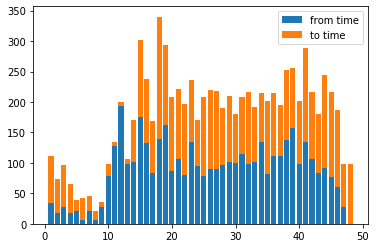

In [162]:
from_ = sdat.groupby(['from_time_slot'])['weekly_flights'].sum()
to_ = sdat.groupby(['to_time_slot'])['weekly_flights'].sum()

if from_.shape[0] != 48:
    for i in range(1, 48, 1):
        try:
            from_[i]
        except KeyError:
            from_[float(i)] = 0
            print(from_[i])

from_.reindex(index = np.arange(1, 49, 1), fill_value = 0)

total_ = from_ + to_
plt.figure()
plt.bar(np.arange(1, 49, 1), from_, label = 'from time')
plt.bar(np.arange(1, 49, 1), to_, bottom = from_, label = 'to time')
plt.legend()
plt.show()

In [154]:
from_.reindex(index = np.arange(1, 49, 1), fill_value = 0)
from_

from_time_slot
1.0      34
2.0      18
3.0      28
4.0      18
5.0      21
6.0       7
7.0      21
9.0       7
10.0     28
11.0     78
12.0    127
13.0    193
14.0     99
15.0    101
16.0    176
17.0    132
18.0     84
19.0    140
20.0    162
21.0     86
22.0    107
23.0     80
24.0    134
25.0     95
26.0     79
27.0     90
28.0     90
29.0     96
30.0    101
31.0    100
32.0    114
33.0     98
34.0    101
35.0    135
36.0     82
37.0    112
38.0    111
39.0    138
40.0    158
41.0     98
42.0    135
43.0    106
44.0     84
45.0     91
46.0     77
47.0     61
48.0     28
8.0       0
Name: weekly_flights, dtype: int64